# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Brand colors
purple = "#5B1F98"   # Primary
green = "#34DFA3"    # Secondary
black = "#010B13"    # Accent

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Inspection

In [5]:
file_path = "/content/drive/MyDrive/Grad Project/data_merged.csv"
df = pd.read_csv(file_path, encoding="latin1")
df.head()

,claim_status,video_transcription_text
0,opinion,my colleagues are willing to say that one-thir...
1,Supported claim,A report from Reuters revealed that WASHINGTON...
2,Supported claim,Reuters said that WASHINGTON U.S. House of Rep...
3,Supported claim,US Census Bureau confirmed that found that soc...
4,claim,which abuts the Sahara to the north and has be...


In [6]:
print("Dataset Shape:", df.shape)
print("==================================================")
print("\nColumn Names:", df.columns.tolist())
print("==================================================")
print("\nBasic Info:")
print(df.info())

Dataset Shape: (47276, 2)

Column Names: ['claim_status', 'video_transcription_text']

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47276 entries, 0 to 47275
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   claim_status              47276 non-null  object
 1   video_transcription_text  47275 non-null  object
dtypes: object(2)
memory usage: 738.8+ KB
None


In [7]:
print("\nUnique labels in claim_status:", df['claim_status'].unique())


Unique labels in claim_status: ['opinion' 'Supported claim' 'claim']


In [8]:
print("\nLabel distribution:")
print(df['claim_status'].value_counts())


Label distribution:
claim_status
claim              19694
Supported claim    15106
opinion            12476
Name: count, dtype: int64


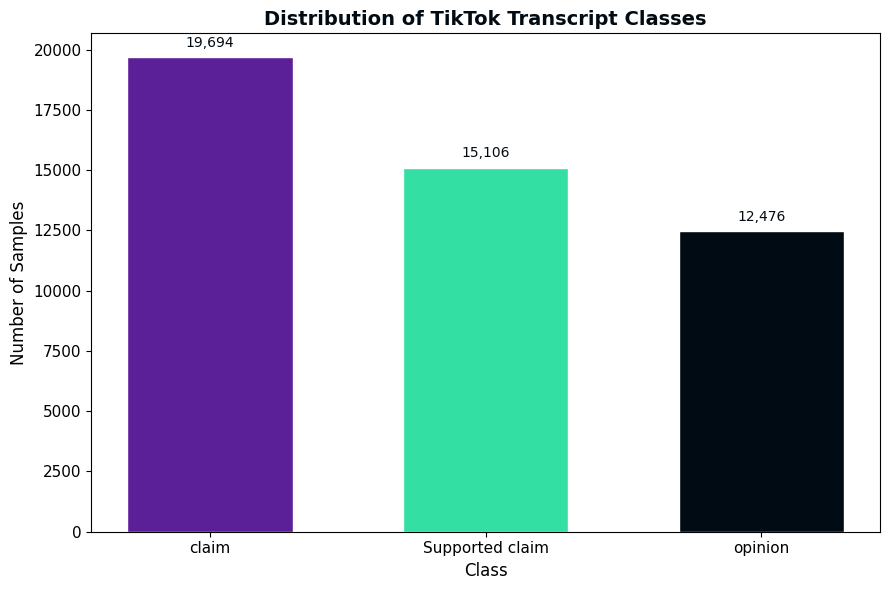

In [9]:
class_counts = df['claim_status'].value_counts()

plt.figure(figsize=(9,6))
bars = plt.bar(class_counts.index, class_counts.values,
               color=[purple, green, black], edgecolor="white", width=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 300, f"{yval:,}",
             ha="center", va="bottom", fontsize=10, color=black)


plt.title("Distribution of TikTok Transcript Classes", fontsize=14, fontweight="bold", color=black)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

In [10]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
claim_status                0
video_transcription_text    1
dtype: int64


In [11]:
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 3269


In [12]:
df=df.drop_duplicates()
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 0


In [13]:
df=df.dropna()

In [14]:
df['text_length'] = df['video_transcription_text'].str.len()
print("\nTranscript length stats:")
print(df['text_length'].describe())


Transcript length stats:
count    44006.000000
mean      1121.607031
std       1583.191279
min          3.000000
25%         87.000000
50%        130.000000
75%       1923.000000
max      29937.000000
Name: text_length, dtype: float64


# Text Analysis


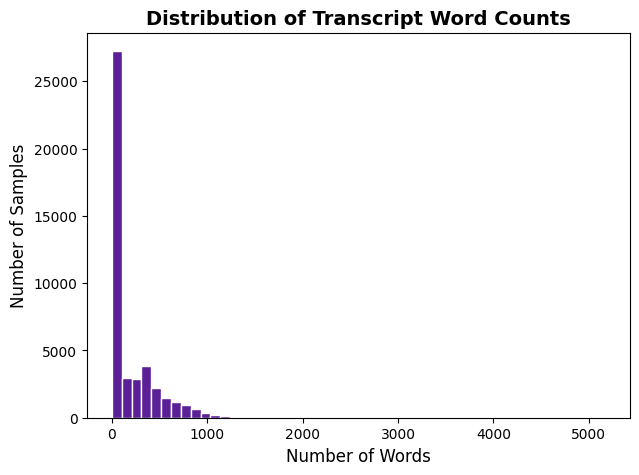

In [15]:
# Word counts

df['word_count'] = df['video_transcription_text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['video_transcription_text'].apply(lambda x: len(str(x)))


plt.figure(figsize=(7,5))
plt.hist(df['word_count'], bins=50, color=purple, edgecolor="white")
plt.title("Distribution of Transcript Word Counts", fontsize=14, fontweight="bold")
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.show()

In [16]:
# to calculate stopword ratio
def stopword_ratio(text):
    words = str(text).lower().split()
    if len(words) == 0:
        return 0
    stopword_count = sum(1 for w in words if w in stop_words)
    return stopword_count / len(words)

# Apply
df['stopword_ratio'] = df['video_transcription_text'].apply(stopword_ratio)

print("\nAverage stopword ratio in dataset:", df['stopword_ratio'].mean())
print("Stopword ratio by class:")
print(df.groupby('claim_status')['stopword_ratio'].mean())


Average stopword ratio in dataset: 0.40131388807676033
Stopword ratio by class:
claim_status
Supported claim    0.358469
claim              0.403277
opinion            0.463027
Name: stopword_ratio, dtype: float64


In [17]:
# Most Common Words per Class

def preprocess_text(text):
    text = re.sub(r'[^a-z\s]', '', str(text).lower())
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

# Apply
df['clean_text'] = df['video_transcription_text'].apply(preprocess_text)

# Function to get top words per class
def get_top_words(label, n=10):
    words = " ".join(df[df['claim_status']==label]['clean_text']).split()
    return Counter(words).most_common(n)

for label in df['claim_status'].unique():
    print(f"\nTop words in {label}:")
    print(get_top_words(label, 10))


Top words in opinion:
[('friends', 2179), ('colleagues', 1958), ('familys', 1160), ('willing', 1136), ('view', 992), ('world', 824), ('family', 776), ('opinion', 696), ('say', 664), ('earth', 606)]

Top words in Supported claim:
[('said', 50238), ('trump', 21119), ('us', 20498), ('would', 15705), ('reuters', 14255), ('president', 12682), ('state', 9395), ('government', 9035), ('states', 8864), ('new', 8584)]

Top words in claim:
[('said', 43023), ('trump', 17972), ('us', 15926), ('would', 13820), ('president', 9356), ('state', 8038), ('government', 7478), ('states', 7395), ('also', 7164), ('people', 7025)]


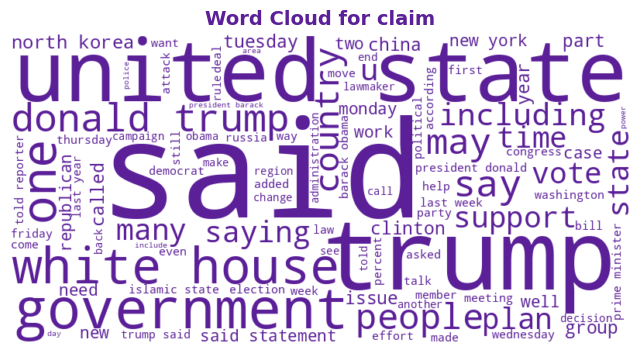

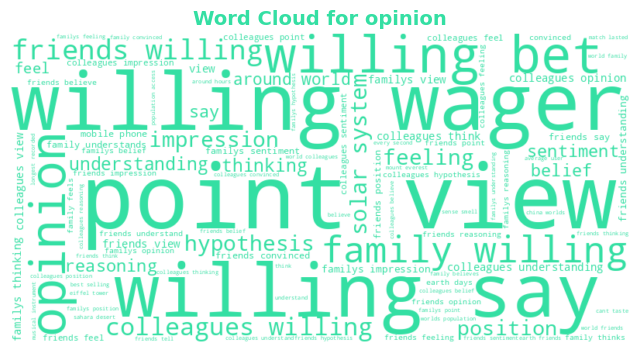

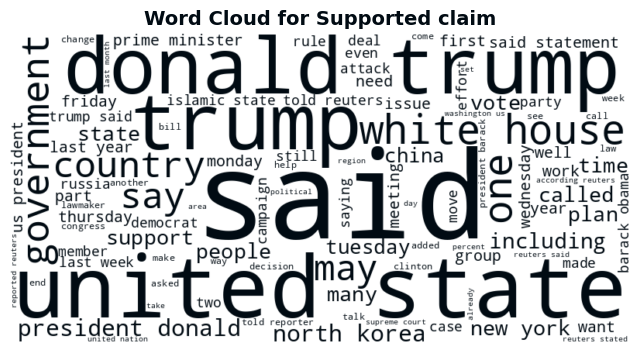

In [18]:
from wordcloud import WordCloud

def plot_wordcloud(label, color="#5B1F98"):
    text = " ".join(df[df['claim_status']==label]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color="white",
                   colormap=None, color_func=lambda *args, **kwargs: color,
                   max_words=100).generate(text)

    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {label}", fontsize=14, fontweight="bold", color=color)
    plt.show()

# Word clouds with brand colors
plot_wordcloud("claim", color="#5B1F98")            # Purple
plot_wordcloud("opinion", color="#34DFA3")         # Green
plot_wordcloud("Supported claim", color=black)


# References